### Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display

In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


### Define Datasets and Dataloaders

In [ ]:
dataset_path = '/content/drive/MyDrive/squares/labeled'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)


# Transformation function to be applied on images
# 1. Horizontally Flip the image with a probability of 30%
# 2. Randomly Rotate the image at an angle between -40 to 40 degress.
# 3. Resize each images to a smallest size of 300 pixels maintaining aspect ratio
# 4. Crop a square of size 256x256 from the center of image
# 5. Convert Image to a Pytorch Tensor
# 6. Normalize the pytorch's tensor using mean & std of imagenet
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),

    transforms.Resize(100),
    transforms.CenterCrop(80),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create a dataset by from the dataset folder by applying the above transformation.
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
print(dataset.class_to_idx)
# Split the dataset into train & test containing 21000 and 5179 images respectively.
train_size = len(dataset) // 100
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (len(dataset)-train_size, train_size))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)



{'black': 0, 'empty': 1, 'white': 2}


### Plot Some Samples of data

In [ ]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))


def PlotClass(dataloader, mclass, title='Images', num=64):
    ret = []

    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])

            if len(ret) == num:
                break

    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))


>>>> torch.Size([4, 3, 80, 80])


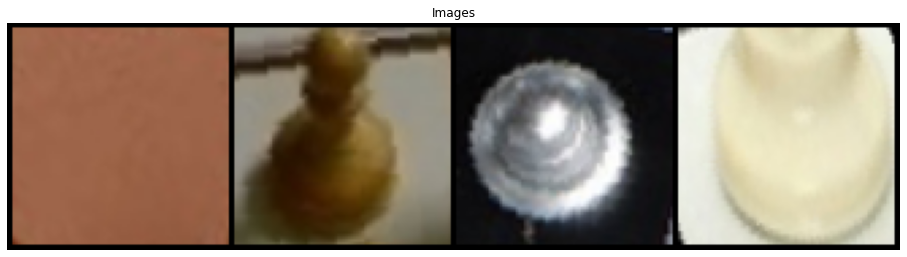

In [ ]:
PlotSamples(train_dataloader)
print(">>>>", next(iter(train_dataloader))[0].to(device).shape)


### Defile Model Architecture

In [ ]:
from drive.MyDrive.models import SquareClassificationModel

model = SquareClassificationModel().to(device)
summary(model, (3,80,80))





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 78, 78]             140
              ReLU-2            [-1, 5, 78, 78]               0
            Conv2d-3            [-1, 5, 76, 76]             230
              ReLU-4            [-1, 5, 76, 76]               0
         MaxPool2d-5            [-1, 5, 38, 38]               0
            Conv2d-6           [-1, 10, 36, 36]             460
              ReLU-7           [-1, 10, 36, 36]               0
            Conv2d-8           [-1, 10, 34, 34]             910
              ReLU-9           [-1, 10, 34, 34]               0
        MaxPool2d-10           [-1, 10, 17, 17]               0
           Conv2d-11           [-1, 20, 15, 15]           1,820
             ReLU-12           [-1, 20, 15, 15]               0
           Conv2d-13           [-1, 20, 13, 13]           3,620
             ReLU-14           [-1, 20,

### Training Procedure

In [ ]:
def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()

    accuracy = []

    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas

        moutput = model(minput) # output by our model

        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters

        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time
            ))

    return total_loss / len(train_dataloader) # Returning Average Training Loss

### Testing Procedure

In [ ]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []

    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()


            # To get the probabilities for different classes we need to apply a softmax operation on moutput
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets

    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader) # Returning Average Testing Loss

### Model, Optimizer & Loss Function

In [ ]:
lr = 0.0001
model = SquareClassificationModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

### Train for 50 epochs

In [ ]:
Test(0)

train_loss = []
test_loss = []

for epoch in range(1, 101):
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')

    if epoch % 10 == 0:
        torch.save(model.state_dict(), 'model_'+str(epoch)+'.pth')

Epoch: [0], Test Loss: 1.1011, Accuracy: 0.31, Time: 0.18 sec
Epoch: [1]/(200/357), Train Loss: 1.0799, Accuracy: 0.47, Time: 3.65 sec
Epoch: [1], Test Loss: 1.0695, Accuracy: 0.50, Time: 0.18 sec


Epoch: [2]/(200/357), Train Loss: 1.0025, Accuracy: 0.51, Time: 3.65 sec
Epoch: [2], Test Loss: 0.9628, Accuracy: 0.50, Time: 0.17 sec


Epoch: [3]/(200/357), Train Loss: 1.0203, Accuracy: 0.51, Time: 3.59 sec
Epoch: [3], Test Loss: 0.9284, Accuracy: 0.56, Time: 0.17 sec


Epoch: [4]/(200/357), Train Loss: 1.1139, Accuracy: 0.59, Time: 3.57 sec
Epoch: [4], Test Loss: 0.9211, Accuracy: 0.81, Time: 0.20 sec


Epoch: [5]/(200/357), Train Loss: 1.1318, Accuracy: 0.64, Time: 3.73 sec
Epoch: [5], Test Loss: 0.7986, Accuracy: 0.62, Time: 0.17 sec


Epoch: [6]/(200/357), Train Loss: 1.0086, Accuracy: 0.70, Time: 3.63 sec
Epoch: [6], Test Loss: 0.7209, Accuracy: 0.75, Time: 0.18 sec


Epoch: [7]/(200/357), Train Loss: 0.4997, Accuracy: 0.73, Time: 3.64 sec
Epoch: [7], Test Loss: 1.0012, Accuracy: 0.

In [ ]:
### Plot Train-Test Loss Curve

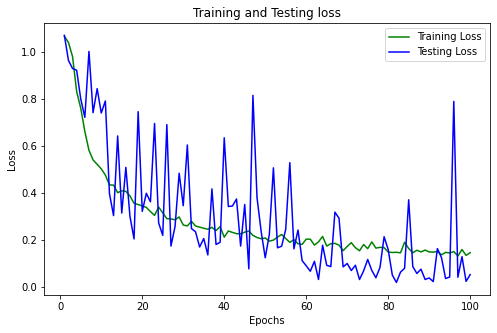

In [89]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test on some random images

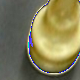

white : 98 % 




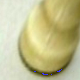

white : 85 % 




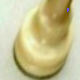

white : 96 % 




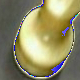

white : 99 % 




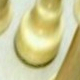

white : 98 % 




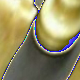

white : 67 % 




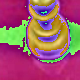

white : 92 % 




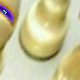

white : 98 % 




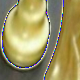

white : 85 % 




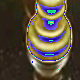

black : 57 % 




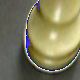

white : 99 % 




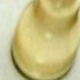

empty : 84 % 




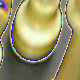

white : 99 % 




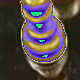

white : 80 % 




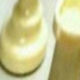

white : 98 % 




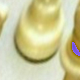

white : 98 % 




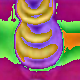

white : 94 % 




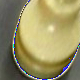

white : 98 % 




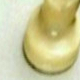

white : 93 % 




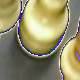

white : 98 % 




In [ ]:
# # Uncomment the below two lines if you want to use the pre trained model for 50 epoch
model = SquareClassificationModel()
model.load_state_dict(torch.load('model_20.pth', map_location=device))
model.cuda()
model.eval()

from glob import glob
from random import shuffle

std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)


denormalize = transforms.Compose([
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToPILImage()
])

classes = ["black", "empty", "white"]

import cv2

with torch.no_grad():
    images = glob('/content/drive/MyDrive/squares/labeled/white/*')[0:20]  # /content/drive/MyDrive/squares/labeled/white/*
    shuffle(images)
    for impath in images:
        image = cv2.imread(impath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        image = torchvision.transforms.Compose([
            torchvision.transforms.Resize(100),
            torchvision.transforms.CenterCrop(80),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image)

        image_tensor = image.view(1, 3, 80, 80).to(device)
        prediction = model(image_tensor)

        predicted_class_id = prediction.argmax().data.item()
        predicted_class = classes[predicted_class_id]

        probability = torch.nn.Softmax(dim=1)(prediction)[0] * 100
        probability = probability.int().data.cpu().numpy()[predicted_class_id]

        display(denormalize(image))
        print(predicted_class, ':', probability, '%', '\n\n')

#model.train()
#pass